# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [81]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../data/samsung_train.txt")
y_train = np.loadtxt("../data/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../data/samsung_test.txt")
y_test = np.loadtxt("../data/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [13]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [16]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [17]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [18]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [19]:
# Ваш код здесь
pca = PCA(random_state=17)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [48]:
# Ваш код здесь
# Вычислим минимальное количество компонент, необходимое для сохранения 90% дисперсии
percent = []
i = 0
while sum(percent) < 90:
    percent.append((pca.explained_variance_ratio_[i] * 100))
    i += 1
print("{} компонент сохраняют {}% дисперсии данных".format(len(percent) + 1, 
          round(sum(percent), 2)))

66 компонент сохраняют 90.05% дисперсии данных


**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [50]:
# Ваш код здесь
print('На первую компоненту приходится {}% дисперсии'.format(round(pca.explained_variance_ratio_[0] * 100)))

На первую компоненту приходится 51.0% дисперсии


Визуализируйте данные в проекции на первые две главные компоненты.

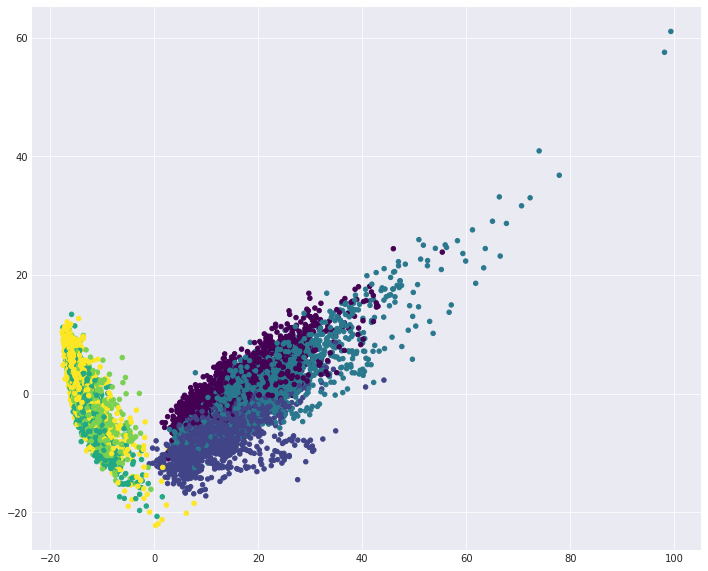

In [52]:
# Ваш код здесь
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

Четко прослеживается 2 кластера

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [54]:
# Ваш код здесь
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=17, tol=0.0001, verbose=0)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

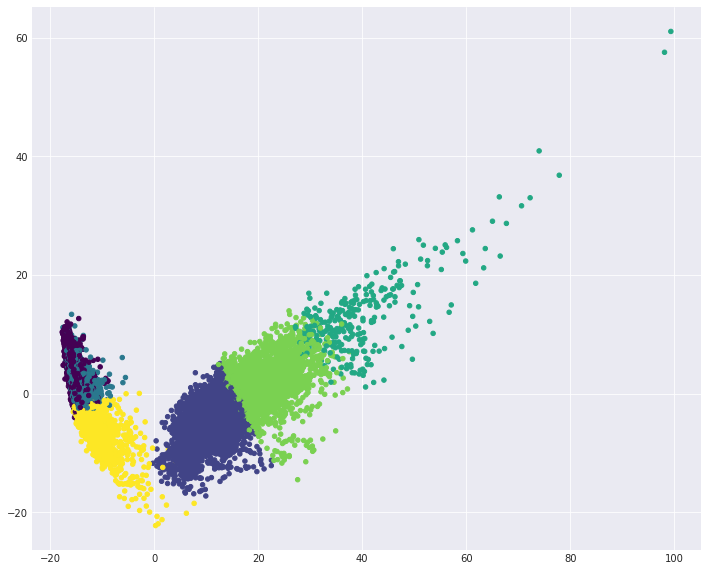

In [57]:
# Ваш код здесь
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:,0],X_pca[:,1] , c=kmeans.labels_, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [59]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,0,77,742,0,1722
подъем вверх по лестнице,0,1242,0,5,295,2,1544
спуск по лестнице,0,321,0,196,889,0,1406
сидение,91,1,1234,0,0,451,1777
стояние,0,0,1340,0,0,566,1906
лежание,1556,5,53,0,0,330,1944
все,1647,2472,2627,278,1926,1349,10299


Очень близки максимальные доли объектов в классе для подъема по лестнице (0,8044) и лежания (0,8004).

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

Text(0, 0.5, '$J(C_k)$')

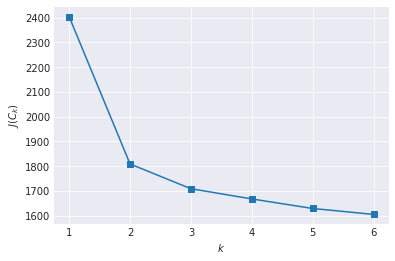

In [62]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 7), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

Согласно методу локтя оптимально выбрать 2 класса.

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [63]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [73]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
ARI_kmeans = adjusted_rand_score(y, kmeans.labels_)
ARI_ag = adjusted_rand_score(y, ag.labels_)
print('ARI для метода агломеративной кластеризации составил {}'.format(round(ARI_ag, 3)))
print('ARI для метода K-средних составил {}'.format(round(ARI_kmeans, 3)))

ARI для метода агломеративной кластеризации составил 0.46
ARI для метода K-средних составил 0.419


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [76]:
# Ваш код здесь
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
optimizer = GridSearchCV(svc, param_grid=svc_params, n_jobs=-1, cv=3)
optimizer.fit(X_train_scaled, y_train)

/home/almaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
# Ваш код здесь
best_svc = optimizer.best_estimator_

In [80]:
optimizer.best_params_

{'C': 0.1}

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

In [82]:
y_predicted = best_svc.predict(X_test_scaled)

In [88]:
np.unique(y_predicted)

array([1, 2, 3, 4, 5, 6])

In [89]:
y_test

array([5, 5, 5, ..., 2, 2, 2])

In [90]:
y_predicted

array([5, 5, 5, ..., 2, 2, 2])

In [83]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – стояние, по полноте – сидение 

По точности - стояние (0,878), по полноте - сидение (0,868)

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


In [91]:
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
svc_pca = LinearSVC(random_state=RANDOM_STATE)
svc_params_pca = {'C': [0.001, 0.01, 0.1, 1, 10]}
optimizer_pca = GridSearchCV(svc_pca, param_grid=svc_params_pca, n_jobs=-1, cv=3)
optimizer_pca.fit(X_train_scaled_pca, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [99]:
best_svc_pca = optimizer_pca.best_estimator_

In [111]:
from sklearn.metrics import accuracy_score
accuracy_1 = accuracy_score(y_test, best_svc.predict(X_test_scaled))
accuracy_2 = accuracy_score(y_test, best_svc_pca.predict(X_test_scaled_pca))
print('Разность между лучшим качеством {} %'.format(accuracy_1 - accuracy_2))

Разность между лучшим качеством 0.0 %


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком